# **Stock-27**

## **Importing Data**

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_raw = pd.read_csv("./Data/individual_book_train/stock_27.csv")

In [17]:
def dfInfo(df: pd.DataFrame) -> None:
    print(df.describe())
    print()
    print(df.shape)
    print()
    print(df.info())
    print()
    print(df.head().to_string())

## **Raw Data Info**

In [43]:
dfInfo(df_raw)

             time_id  seconds_in_bucket     bid_price1     ask_price1  \
count  873499.000000      873499.000000  873499.000000  873499.000000   
mean    16007.459713         292.141403       0.999241       1.000883   
std      9379.509645         173.528286       0.005421       0.005445   
min         5.000000           0.000000       0.897584       0.903124   
25%      7775.000000         141.000000       0.997414       0.998853   
50%     15853.000000         289.000000       0.999313       1.000589   
75%     23955.000000         442.000000       1.001049       1.002478   
max     32767.000000         599.000000       1.075063       1.082831   

          bid_price2     ask_price2      bid_size1      ask_size1  \
count  873499.000000  873499.000000  873499.000000  873499.000000   
mean        0.998942       1.001184      94.563099      95.047862   
std         0.005441       0.005476     105.848809     105.229050   
min         0.895621       0.903194       1.000000       1.000000 

## **Feature Engineering**

In [3]:
df = df_raw.copy()

Generating Midpoint1, Midpoint2, Bid-Ask-Spread1, Bid-Ask-Spread2, Log-Returns

In [4]:
df["midpoint1"] = (df["ask_price1"] + df["bid_price1"])/2
df["midpoint2"] = (df["ask_price2"] + df["bid_price2"])/2

df["bid_ask_spread1"] = df["ask_price1"] - df["bid_price1"]
df["bid_ask_spread2"] = df["ask_price2"] - df["bid_price2"]

df['log_return'] = np.log(df['midpoint1'] / df['midpoint1'].shift(1))
df = df.dropna(subset=['log_return'])

In [9]:
dfInfo(df)

             time_id  seconds_in_bucket     bid_price1     ask_price1  \
count  873498.000000      873498.000000  873498.000000  873498.000000   
mean    16007.478033         292.141737       0.999241       1.000883   
std      9379.499386         173.528104       0.005421       0.005445   
min         5.000000           0.000000       0.897584       0.903124   
25%      7775.000000         141.000000       0.997414       0.998853   
50%     15853.000000         289.000000       0.999313       1.000589   
75%     23955.000000         442.000000       1.001049       1.002478   
max     32767.000000         599.000000       1.075063       1.082831   

          bid_price2     ask_price2      bid_size1      ask_size1  \
count  873498.000000  873498.000000  873498.000000  873498.000000   
mean        0.998942       1.001184      94.563089      95.047947   
std         0.005441       0.005476     105.848869     105.229080   
min         0.895621       0.903194       1.000000       1.000000 

## **Grid Search for Rolling Realized Volatility**

> Warning: This code takes time to run and is not realted to main code, so can be skipped.

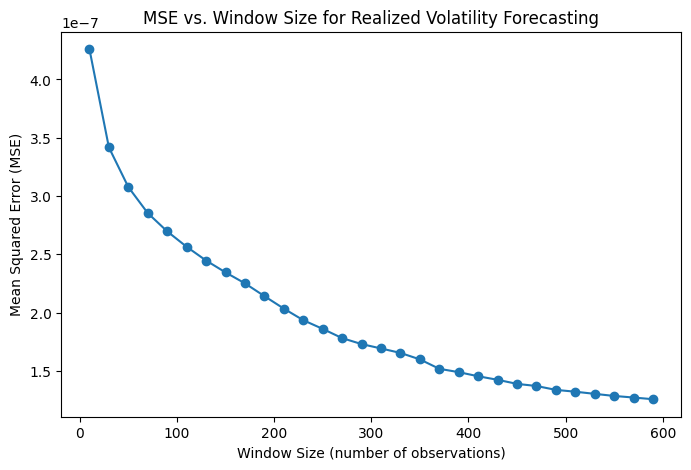

In [10]:
window_sizes = range(10, 600, 20)
results = []

for w in window_sizes:
    col_name = f'rolling_rv_{w}'
    df[col_name] = df['log_return'].rolling(window=w).apply(lambda x: np.sqrt(np.sum(x**2)), raw=True)
    df[f'forecast_{w}'] = df[col_name].shift(1)
    valid = df.dropna(subset=[col_name, f'forecast_{w}'])
    mse = np.mean((valid[col_name] - valid[f'forecast_{w}'])**2)
    results.append({'window_size': w, 'mse': mse})

results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.plot(results_df['window_size'], results_df['mse'], marker='o')
plt.xlabel('Window Size (number of observations)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Window Size for Realized Volatility Forecasting')
plt.show()

## **Feature Engineering**

Generating Features Rolling Realized Volatility, Integrated Variance, Integrated Volatility, Normalized-BAS1, Normalized-BAS2, Order-Book-Imbalance

In [5]:
window_size = 150
df['rolling_rv'] = df['log_return'].rolling(window=window_size).apply(lambda x: np.sqrt(np.sum(x**2)), raw=True)
df = df.dropna()

In [6]:
df['integrated_variance'] = (df['log_return'] ** 2).cumsum()
df['integrated_volatility'] = np.sqrt(df['integrated_variance'])

In [7]:
df["normalized_spread1"] = df["bid_ask_spread1"]/df["midpoint1"]
df["normalized_spread2"] = df["bid_ask_spread2"]/df["midpoint2"]

In [8]:
df["order_book_imbalance"] = df["bid_ask_spread1"]/df["bid_ask_spread2"]

In [50]:
dfInfo(df)

             time_id  seconds_in_bucket     bid_price1     ask_price1  \
count  873349.000000      873349.000000  873349.000000  873349.000000   
mean    16010.208178         292.162143       0.999240       1.000882   
std      9377.970003         173.531999       0.005421       0.005445   
min         5.000000           0.000000       0.897584       0.903124   
25%      7783.000000         141.000000       0.997413       0.998852   
50%     15853.000000         289.000000       0.999312       1.000589   
75%     23955.000000         442.000000       1.001047       1.002477   
max     32767.000000         599.000000       1.075063       1.082831   

          bid_price2     ask_price2      bid_size1      ask_size1  \
count  873349.000000  873349.000000  873349.000000  873349.000000   
mean        0.998941       1.001184      94.574015      95.055215   
std         0.005441       0.005476     105.852905     105.232742   
min         0.895621       0.903194       1.000000       1.000000 

## **Grid Search For Adverse Cost Delta**

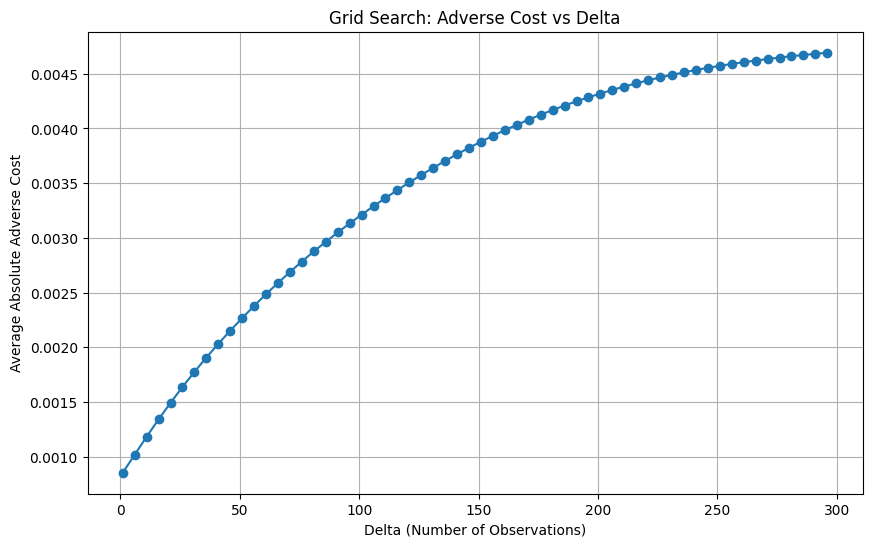

In [17]:
delta_values = range(1, 301, 5)
results = []

for delta in delta_values:
    temp_df = df.copy()
    temp_df['future_midpoint'] = temp_df['midpoint1'].shift(-delta)
    temp_df['adverse_cost_buy'] = temp_df['future_midpoint'] - temp_df['ask_price1']
    avg_abs_cost = temp_df['adverse_cost_buy'].abs().mean()
    results.append({'delta': delta, 'avg_abs_adverse_cost': avg_abs_cost})

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['delta'], results_df['avg_abs_adverse_cost'], marker='o')
plt.xlabel('Delta (Number of Observations)')
plt.ylabel('Average Absolute Adverse Cost')
plt.title('Grid Search: Adverse Cost vs Delta')
plt.grid(True)
plt.show()

## **Feature Engineering**

Generating Future-Midpoint, Adverse-Cost-Buy, Adverse-Cost-Sell, Cumulative-OBI, LOB Entropy, LOB_entropy_normalized, and Microprice

In [9]:
delta = 5

df['future_midpoint'] = df['midpoint1'].shift(-delta)
df['adverse_cost_buy'] = df['future_midpoint'] -  df['ask_price1']
df['adverse_cost_sell'] = df['bid_price1'] - df['future_midpoint']

In [10]:
df["cumulative_order_book_imbalance"] = df["order_book_imbalance"].cumsum()
df = df.dropna()

In [11]:
def compute_lob_entropy(row, normalize=False):
    volumes = np.array([row['bid_size1'], row['bid_size2'], row['ask_size1'], row['ask_size2']], dtype=float)
    total_volume = volumes.sum()
    if total_volume == 0:
        return 0.0
    p = volumes / total_volume
    p = p[p > 0]
    entropy = -np.sum(p * np.log(p))
    
    if normalize:
        entropy /= np.log(4)
    return entropy

df['LOB_entropy'] = df.apply(compute_lob_entropy, axis=1)
df['LOB_entropy_normalized'] = df.apply(lambda row: compute_lob_entropy(row, normalize=True), axis=1)

In [12]:
df["microprice"] = (df["ask_price1"]*df["bid_size1"] + df["bid_price1"]*df["ask_size1"])/(df["bid_size1"] + df["ask_size1"])

In [13]:
df["lob_slope"] = ((df['ask_price2'] - df['ask_price1']) / (df['ask_size2'] + 1e-9)) - \
    ((df['bid_price1'] - df['bid_price2']) / (df['bid_size2'] + 1e-9))

In [56]:
dfInfo(df)

             time_id  seconds_in_bucket     bid_price1     ask_price1  \
count  873344.000000      873344.000000  873344.000000  873344.000000   
mean    16010.112243         292.160433       0.999240       1.000882   
std      9377.911138         173.531025       0.005421       0.005445   
min         5.000000           0.000000       0.897584       0.903124   
25%      7783.000000         141.000000       0.997413       0.998852   
50%     15853.000000         289.000000       0.999312       1.000589   
75%     23955.000000         442.000000       1.001047       1.002477   
max     32767.000000         599.000000       1.075063       1.082831   

          bid_price2     ask_price2      bid_size1      ask_size1  \
count  873344.000000  873344.000000  873344.000000  873344.000000   
mean        0.998941       1.001184      94.574502      95.054983   
std         0.005441       0.005476     105.853011     105.232845   
min         0.895621       0.903194       1.000000       1.000000 

## **Additional Features**

In [14]:
df['lob_slope_top2'] = (
    ((df['ask_price2'] - df['ask_price1']) + (df['bid_price1'] - df['bid_price2']))
    / ((df['ask_size2'] + df['ask_size1']) + (df['bid_size1'] + df['bid_size2']))
)

In [15]:
df['trade_sign'] = np.sign(df['log_return'])  # +1 if price up, -1 if price down

In [16]:
df['jump_in_quotes'] = (df['ask_price1'].diff().abs() + df['bid_price1'].diff().abs())

In [18]:
df.dropna()
dfInfo(df)

             time_id  seconds_in_bucket     bid_price1     ask_price1  \
count  873344.000000      873344.000000  873344.000000  873344.000000   
mean    16010.112243         292.160433       0.999240       1.000882   
std      9377.911138         173.531025       0.005421       0.005445   
min         5.000000           0.000000       0.897584       0.903124   
25%      7783.000000         141.000000       0.997413       0.998852   
50%     15853.000000         289.000000       0.999312       1.000589   
75%     23955.000000         442.000000       1.001047       1.002477   
max     32767.000000         599.000000       1.075063       1.082831   

          bid_price2     ask_price2      bid_size1      ask_size1  \
count  873344.000000  873344.000000  873344.000000  873344.000000   
mean        0.998941       1.001184      94.574502      95.054983   
std         0.005441       0.005476     105.853011     105.232845   
min         0.895621       0.903194       1.000000       1.000000 

## **Plotting**

In [ ]:
def plot_all_features_and_save(df, save_folder='./cache/Plots'):
    """
    For each column in df, create:
      - A histogram (saved as {column}_hist.png)
      - A time-series line plot (saved as {column}_time_series.png)
    All plots will be saved under 'save_folder'.
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for col in df.columns:
        plt.figure()
        df[col].plot(kind='hist', bins=50)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        
        hist_filename = os.path.join(save_folder, f"{col}_hist.png")
        plt.savefig(hist_filename, dpi=300, bbox_inches='tight')
        plt.close()
        
        plt.figure()
        df[col].plot()
        plt.title(f"Time Series of {col}")
        plt.xlabel("Index (row)")
        plt.ylabel(col)
        
        time_filename = os.path.join(save_folder, f"{col}_time_series.png")
        plt.savefig(time_filename, dpi=300, bbox_inches='tight')
        plt.close()


plot_all_features_and_save(df)

## **Correlation heatmap**

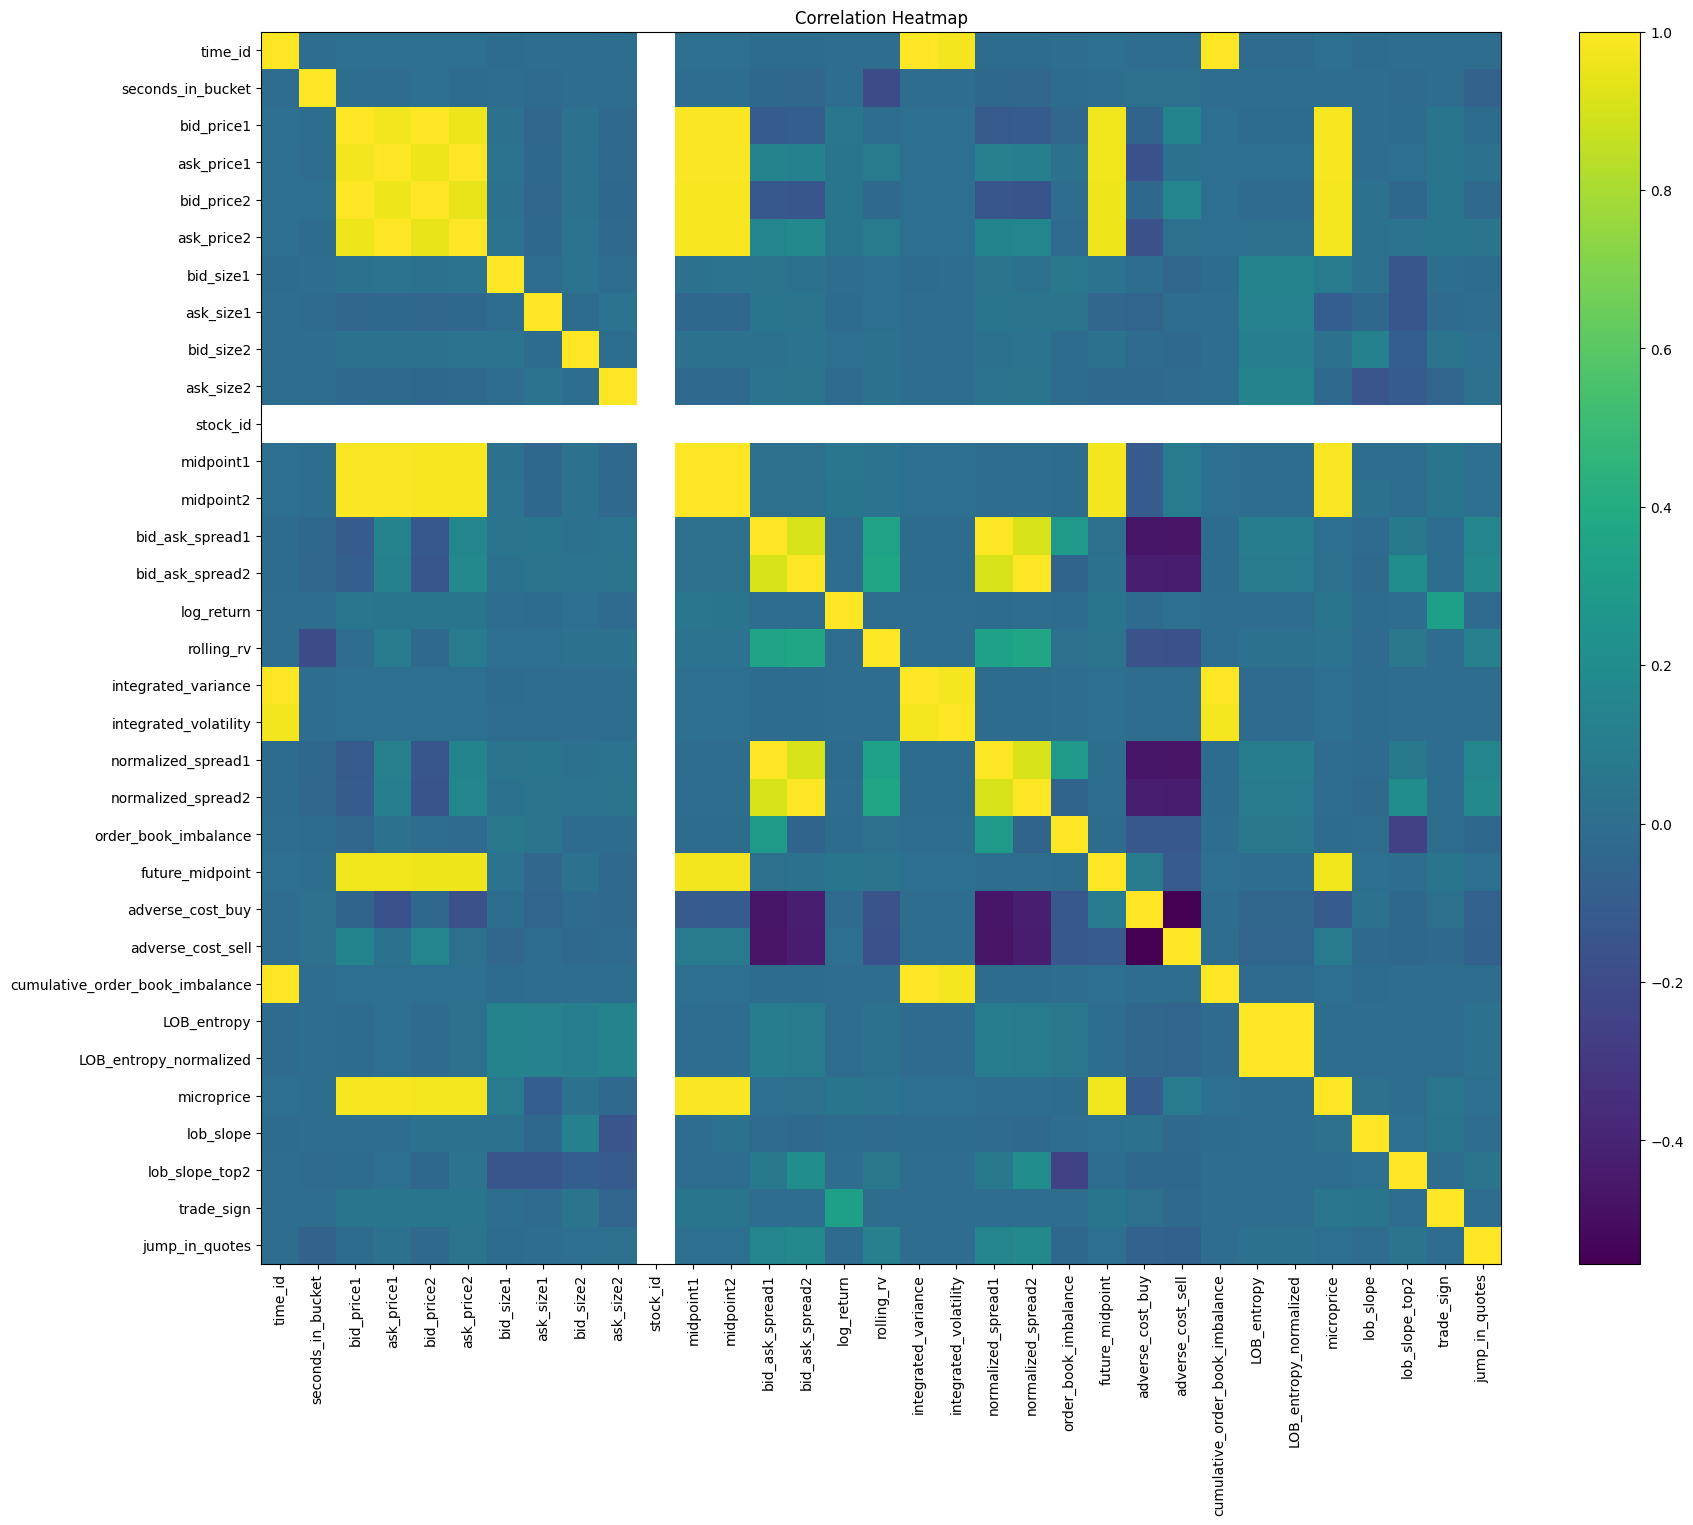

<Figure size 2000x1600 with 0 Axes>

In [28]:
def plot_correlation_heatmap(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(20, 16))
    im = plt.imshow(corr_matrix, aspect='auto')
    plt.title("Correlation Heatmap")
    plt.colorbar(im)
    num_cols = len(corr_matrix.columns)
    plt.xticks(range(num_cols), corr_matrix.columns, rotation=90)
    plt.yticks(range(num_cols), corr_matrix.columns)

    plt.figure(figsize=(20, 16))
    plt.show()

plot_correlation_heatmap(df)


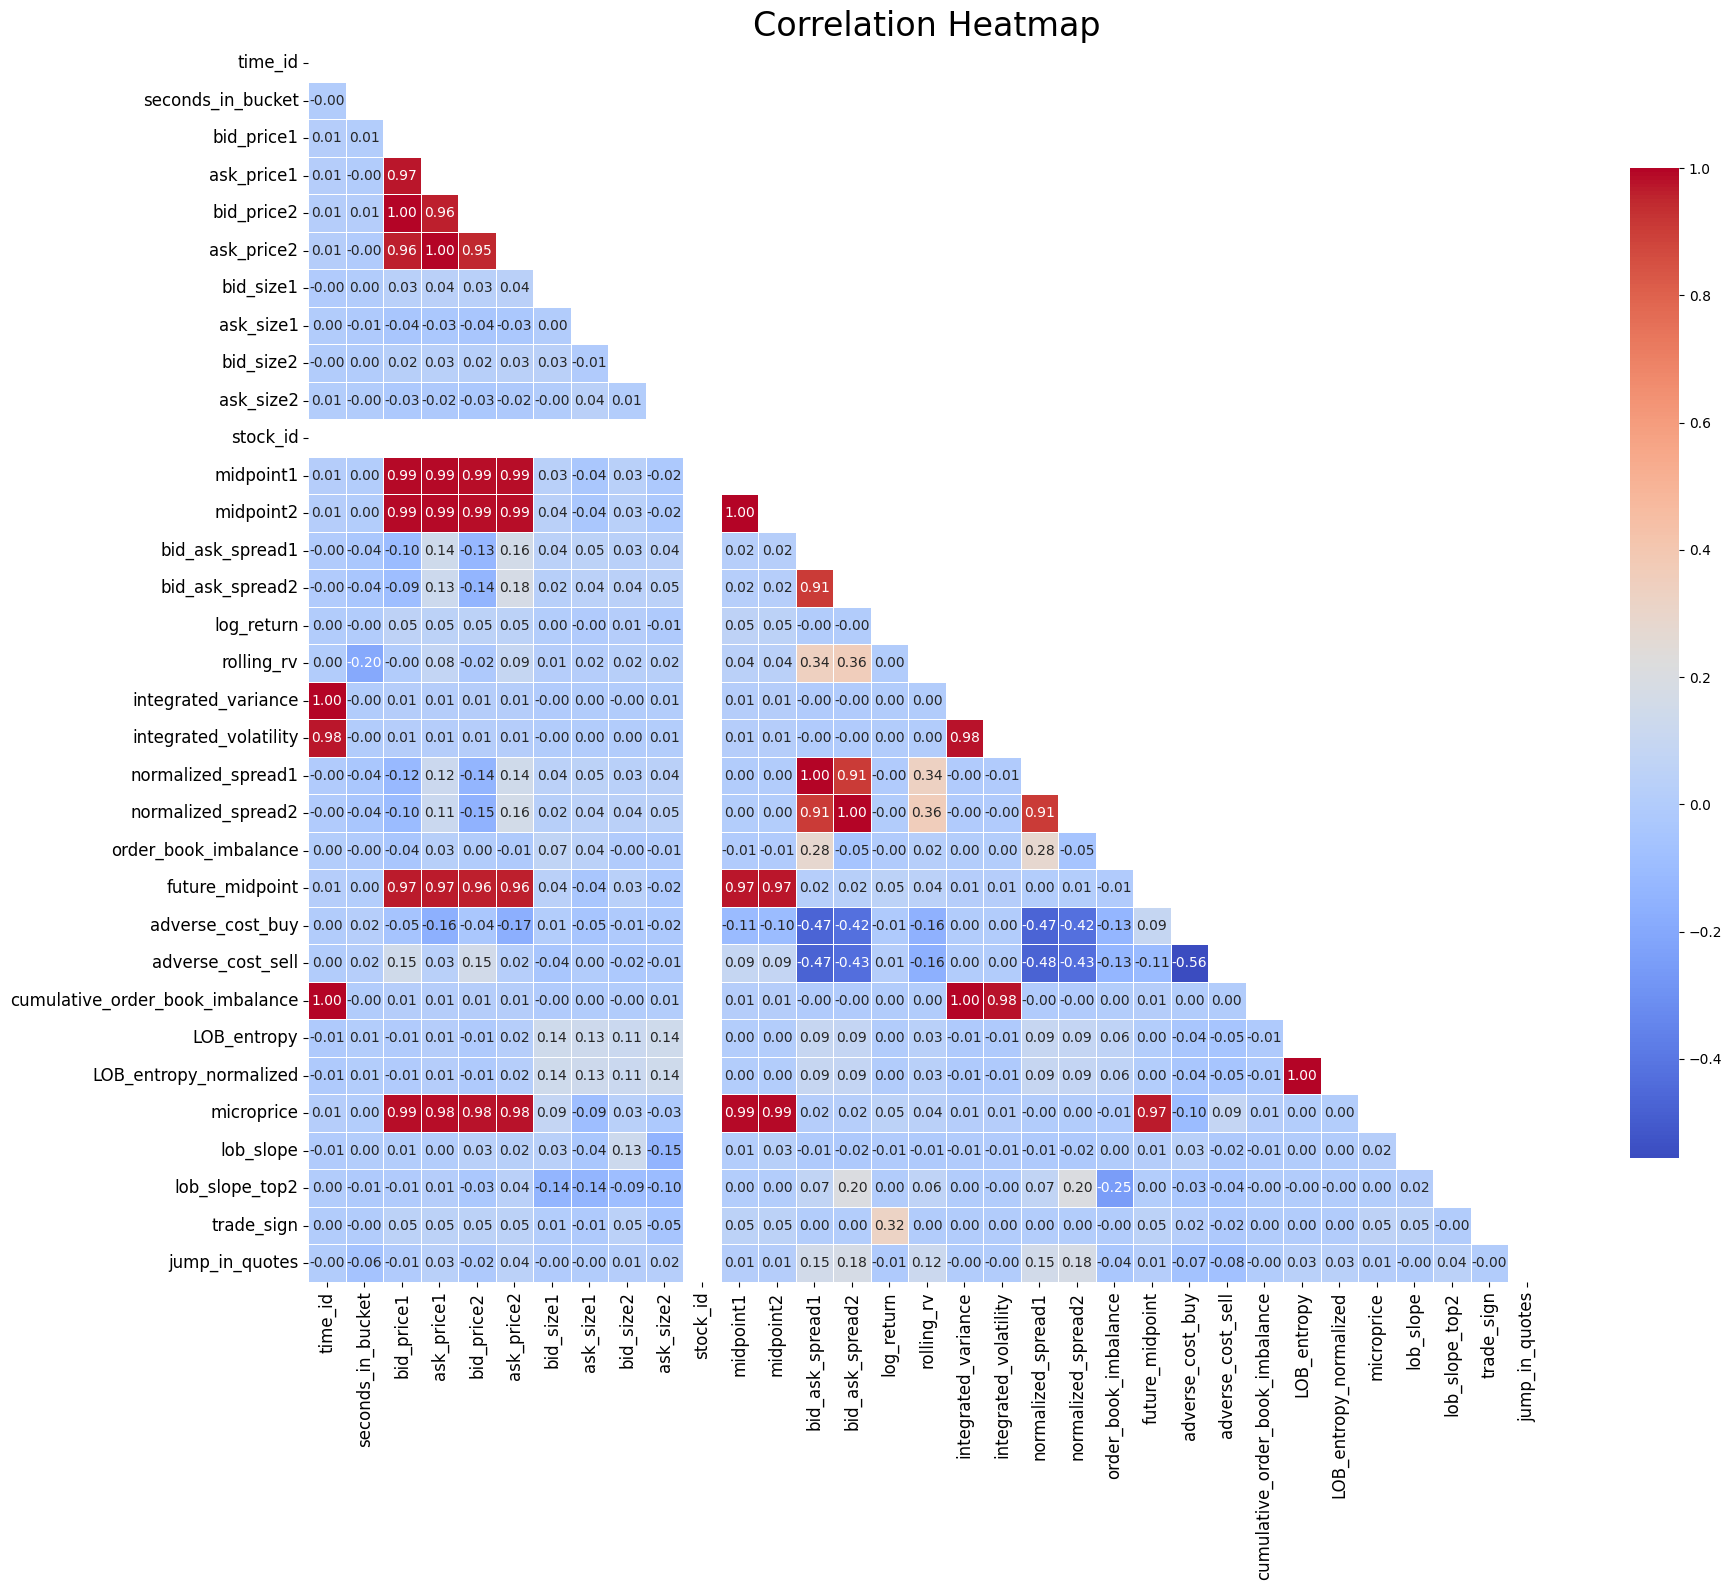

In [36]:
def plot_correlation_heatmap(df):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", mask=mask, cmap='coolwarm',
                linewidths=0.5, linecolor='white', square=True, cbar_kws={"shrink": 0.8})
    
    plt.title("Correlation Heatmap", fontsize=24)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(df)
